<a href="https://colab.research.google.com/github/sarmientoj24/EE298/blob/master/Rerun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.layers import Lambda, Input, Dense, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Activation, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt
import os
# Main cell to run
from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#### HELPER FUNCTIONS
import cv2
import glob, os
import pandas as pd
from PIL import Image
import numpy as np

import imageio
def read_imgs_to_np_from_folder(img_folder):
  cwd = os.getcwd()

  # os.chdir(img_folder + '/')

  imgs = glob.glob(img_folder + '*.jpg')
  # height,width = imageio.imread(imgs[0]).shape[:2]

  X = []
  count = 0
  for f in imgs:
    x = imageio.imread(f)

    if len(x.shape) == 3 and x.shape[0] == 260 and x.shape[1] == 195 and x.shape[2] == 3:
      x = x.astype(np.float32) / 255.0
      X.append(x)
      del x
      count += 1
    if count % 3000 == 0:
      print("Traversed ", count)
    
  X = np.array(X)
  print(X.shape)
  return X

In [0]:
!chmod 600 '/content/drive/My Drive/rerun/new_imgs6.tar.xz'
!cp '/content/drive/My Drive/rerun/new_imgs6.tar.xz' '/content/data_im/'
!tar -xf '/content/data_im/new_imgs6.tar.xz'

In [5]:
# x_train = read_imgs_to_np_from_folder('/content/new_imgs4/')
cwd = os.getcwd()

# os.chdir(img_folder + '/')

imgs = glob.glob('/content/new_imgs6/' + '*.jpg')
# height,width = imageio.imread(imgs[0]).shape[:2]

x_train = []
count = 0
for f in imgs:
  x = imageio.imread(f)

  if len(x.shape) == 3 and x.shape[0] == 240 and x.shape[1] == 180 and x.shape[2] == 3:
    x = x.astype(np.float32) / 255.0
    x_train.append(x)
    del x
    count += 1
  if count % 3000 == 0:
    print("Traversed ", count)
  
x_train = np.array(x_train)

Traversed  3000
Traversed  6000
Traversed  9000
Traversed  12000
Traversed  15000
Traversed  18000
Traversed  21000


In [0]:
!chmod 777 '/content/drive/My Drive/rerun/'













Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 240, 180, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 120, 90, 16)  208         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 120, 90, 16)  64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 120, 90, 16)  0           batch_normalization_1[0][0]      
________________________________________________________________________________

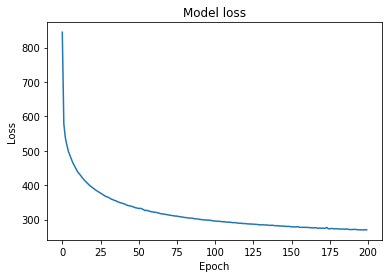

<Figure size 432x288 with 0 Axes>

In [7]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon

z_dim = 16
kernel_size = 2
latent_dim = 16
filter_dims = [16, 32, 64]
filter_decoder = [64, 32, 16]
image_shape = (240, 180, 3)
epochs = 200
batch_size = 16
from keras import layers, initializers
from keras.layers import Dropout

inputs = Input(shape=image_shape, name='encoder_input')
x = inputs
for i in range(2):
  filters = filter_dims[i]
  x = Conv2D(filters=filters,
            kernel_size=kernel_size,
            strides=2,
            padding='same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.1)(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(128)(x)
x = LeakyReLU(0.1)(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var',
      kernel_initializer=initializers.Constant(0),
      bias_initializer=initializers.Constant(0))(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(128)(latent_inputs)
x = LeakyReLU(0.1)(x)
x = Dense(shape[1] * shape[2] * shape[3])(x)
x = LeakyReLU(0.1)(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
  filters = filter_decoder[i]
  x = Conv2DTranspose(filters=filters,
                      kernel_size=kernel_size,
                      strides=2,
                      padding='same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.1)(x)

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
vae.summary()

reconstruction_loss = mse(K.flatten(inputs),
                                           K.flatten(outputs))

reconstruction_loss *= image_shape[0] * image_shape[1]
kl_loss = 1 + (z_log_var) - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

# def vae_loss(y_true, y_pred):
#     """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
#     recon = K.sum(K.binary_crossentropy(y_true, y_pred))
#     kl = 0.5 * K.sum(K.exp(z_log_sigma) + K.square(z_mean) - 1. - z_log_sigma, axis=1)
#     return recon + kl
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

history = vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1)
vae.save('/content/drive/My Drive/rerun/vae_binary_cross_adam_epoch_only_relu_200.h5')
encoder.save('/content/drive/My Drive/rerun/encoder_binary_cross_adam_epoch_only_relu_200.h5')
decoder.save('/content/drive/My Drive/rerun/decoder_binary_cross_adam_epoch_only_relu_200.h5')

plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
plt.savefig('/content/drive/My Drive/rerun/model_loss.png')